# RandomForest


## 1. Import Libraries

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib, time, os

os.makedirs('/content/report_outputs', exist_ok=True)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-7
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100


## 2. Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Lab1_TK/household.csv', parse_dates=['date'])
df = df.set_index('date').sort_index()
df = df.drop(columns=['main','description'], errors='ignore')
df = df.resample('H').mean()
df = df.interpolate()
df.head()

/tmp/ipython-input-1634932821.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,pressure,humidity,speed,deg,temp_t+1,feels_like_t+1
date,,,,,,,,,,,,,,,,
2022-11-05 14:00:00,248.780000,2.301455,122.312727,127.066364,281.159455,0.885213,24.246364,23.728182,23.689091,27.495091,1011.909091,38.436364,0.081818,8.000000,29.606000,27.912000
2022-11-05 15:00:00,202.663333,2.062333,122.410000,136.873500,252.208500,0.802048,24.302000,23.765333,24.156667,27.498000,1010.666667,37.366667,2.912167,333.900000,29.721333,27.978333
2022-11-05 16:00:00,198.863333,1.933833,122.725000,116.217833,234.804833,0.811255,24.174000,23.605833,24.002500,27.184000,1011.416667,36.666667,2.322667,326.750000,29.847667,28.139333
2022-11-05 17:00:00,390.181667,3.656500,122.185000,202.436167,445.381500,0.846390,23.485667,22.830667,23.046500,25.496167,1010.600000,36.083333,2.455000,302.833333,27.960167,26.480667
2022-11-05 18:00:00,443.036667,3.839500,121.908333,143.828000,467.515167,0.946220,21.693667,20.933333,21.497667,21.934500,1008.816667,38.783333,2.269500,267.316667,26.836500,26.228167


## 3. Feature Engineering

In [ ]:
data = df.copy()
data['ap_lag_1h'] = data['active_power'].shift(1)
data['ap_lag_24h'] = data['active_power'].shift(24)
data['ap_roll_24h'] = data['active_power'].rolling(24, min_periods=1).mean()

data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = (data['weekday'] >= 5).astype(int)

data = data.dropna()
data.head()

,active_power,current,voltage,reactive_power,apparent_power,power_factor,temp,feels_like,temp_min,temp_max,...,speed,deg,temp_t+1,feels_like_t+1,ap_lag_1h,ap_lag_24h,ap_roll_24h,hour,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2022-11-06 14:00:00,163.376667,1.701333,122.801667,125.215667,208.594833,0.762977,28.653167,27.250167,28.052333,28.893333,...,3.781167,358.783333,24.246333,23.729500,224.355000,248.780000,273.720891,14,6,1
2022-11-06 15:00:00,297.003333,2.743833,122.213333,143.578833,333.192167,0.862192,28.226667,26.947833,28.041500,28.638500,...,4.559333,310.116667,24.302000,23.765333,163.376667,202.663333,277.651724,15,6,1
2022-11-06 16:00:00,396.440000,3.489667,122.251667,142.417333,426.028167,0.914212,27.816167,26.716833,27.412667,28.493333,...,4.938667,307.800000,24.174000,23.605833,297.003333,198.863333,285.884085,16,6,1
2022-11-06 17:00:00,311.295000,2.855333,122.973333,157.872333,350.784500,0.891425,25.777500,25.265667,24.591667,26.621500,...,4.757667,299.166667,23.485667,22.830667,396.440000,390.181667,282.597141,17,6,1
2022-11-06 18:00:00,443.610000,4.006667,122.463333,199.319167,487.643667,0.907523,23.328667,22.383333,21.573000,23.595667,...,4.779167,317.816667,21.693667,20.933333,311.295000,443.036667,282.621030,18,6,1


## 4. Time-based Split 85/10/5

In [ ]:
n=len(data)
train_end=int(n*0.85)
val_end=int(n*0.95)

train=data.iloc[:train_end]
val=data.iloc[train_end:val_end]
test=data.iloc[val_end:]

X_train=train.drop(columns=['active_power'])
y_train=train['active_power']
X_val=val.drop(columns=['active_power'])
y_val=val['active_power']
X_test=test.drop(columns=['active_power'])
y_test=test['active_power']

print('X_train =' ,X_train.shape)
print('X_val = ' ,X_val.shape)
print('X_test = ',X_test.shape)


X_train = (8678, 21)
X_val =  (1021, 21)
X_test =  (511, 21)


## 5. Scaling

In [ ]:
scaler=StandardScaler()
X_train_s=scaler.fit_transform(X_train)
X_val_s=scaler.transform(X_val)
X_test_s=scaler.transform(X_test)

## 6. Subsample Tuning (40%) — GRID B

In [ ]:
sub_size = int(len(X_train_s) * 40)
X_sub = X_train_s[:sub_size]
y_sub = y_train.iloc[:sub_size]

print("Subsample size:", X_sub.shape)

model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators':[50,100,150],
    'max_depth':[10,20,None],
    'min_samples_leaf':[1,2,3]
}

tscv = TimeSeriesSplit(n_splits=3)

gscv = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start=time.time()
gscv.fit(X_sub, y_sub)
end=time.time()

print("Tuning time:", end-start)
print("Best params:", gscv.best_params_)

results=pd.DataFrame(gscv.cv_results_)
results['MAE'] = -results['mean_test_score']

rmse_list=[]; r2_list=[]; mape_list=[]
for i in range(len(results)):
    params = results.loc[i,'params']
    temp = RandomForestRegressor(random_state=42,n_jobs=-1, **params)
    temp.fit(X_sub, y_sub)
    preds=temp.predict(X_val_s)
    rmse_list.append(np.sqrt(mean_squared_error(y_val, preds)))
    r2_list.append(r2_score(y_val, preds))
    mape_list.append(mape(y_val, preds))

results['RMSE']=rmse_list
results['R2']=r2_list
results['MAPE']=mape_list

comparison = results[['params','MAE','MAPE','RMSE','R2']].sort_values(by='MAE')
comparison.to_csv('/content/report_outputs/rf_model_comparison_v4.csv',index=False)
comparison


Subsample size: (8678, 21)
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Tuning time: 658.0200891494751
Best params: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 150}


,params,MAE,MAPE,RMSE,R2
23,"{'max_depth': None, 'min_samples_leaf': 2, 'n_...",5.796980,1.083060,3.141618,0.998773
14,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es...",5.797013,1.083167,3.141588,0.998773
20,"{'max_depth': None, 'min_samples_leaf': 1, 'n_...",5.800302,1.087938,3.154383,0.998763
19,"{'max_depth': None, 'min_samples_leaf': 1, 'n_...",5.810432,1.089771,3.181780,0.998742
22,"{'max_depth': None, 'min_samples_leaf': 2, 'n_...",5.817631,1.088140,3.168144,0.998753
13,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es...",5.817695,1.088333,3.168286,0.998752
11,"{'max_depth': 20, 'min_samples_leaf': 1, 'n_es...",5.818293,1.088056,3.148395,0.998768
10,"{'max_depth': 20, 'min_samples_leaf': 1, 'n_es...",5.828582,1.090219,3.182559,0.998741
21,"{'max_depth': None, 'min_samples_leaf': 2, 'n_...",5.847964,1.106665,3.251450,0.998686
12,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es...",5.848232,1.106840,3.252670,0.998685


## 7. Validation Evaluation

In [ ]:
best = gscv.best_estimator_
pred_val = best.predict(X_val_s)

mae_val = mean_absolute_error(y_val, pred_val)
mape_val = mape(y_val, pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))                                                 
r2_val = r2_score(y_val, pred_val)

(mae_val, mape_val, rmse_val, r2_val)
print('mae_val =',mae_val)
print('mape_val =',mape_val)
print('rmse_val =',rmse_val)
print('r2_val =',r2_val)

mae_val = 2.152441731881762
mape_val = 1.0830597640510533
rmse_val = 3.1416183572695453
r2_val = 0.9987733788128589


## 8. Final Training + Test Evaluation (Full Data)

In [ ]:
X_trainval = np.vstack([X_train_s, X_val_s])
y_trainval = pd.concat([y_train, y_val])

final_model = RandomForestRegressor(**gscv.best_params_, random_state=42, n_jobs=-1)
final_model.fit(X_trainval, y_trainval)

pred_test = final_model.predict(X_test_s)

mae_test = mean_absolute_error(y_test, pred_test)
mape_test = mape(y_test, pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
r2_test = r2_score(y_test, pred_test)

(mae_test, mape_test, rmse_test, r2_test)
print('mae_test =',mae_test)
print('mape_test =',mape_test)
print('rmse_test =',rmse_test)
print('r2_test =',r2_test)


mae_test = 3.029620644811419
mape_test = 2.2495157535923327
rmse_test = 4.653532444604543
r2_test = 0.9980140542574952


## 9. Feature Importance

In [ ]:
fi = pd.Series(final_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
fi.to_csv('/content/report_outputs/rf_feature_importance_v4.csv')
fi.head(20)

,0
apparent_power,0.968091
current,0.019415
power_factor,0.011206
reactive_power,0.000997
ap_lag_1h,0.000029
ap_roll_24h,0.000029
deg,0.000026
ap_lag_24h,0.000025
humidity,0.000022
pressure,0.000021


## 10. Actual vs Predicted (300 sample)

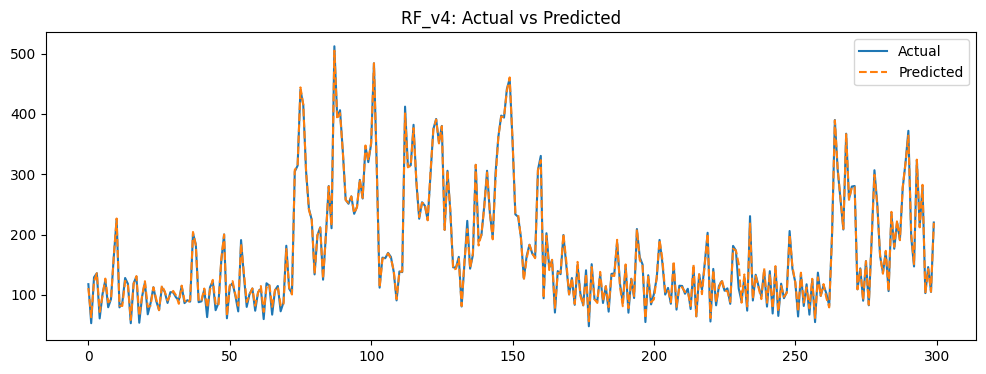

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:300], label='Actual')
plt.plot(pred_test[:300], label='Predicted', linestyle='--')
plt.legend()
plt.title("RF_v4: Actual vs Predicted")
plt.show()